In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
def euclid(df):
    return np.sqrt((df['centroid_x'] - df['centroid_x'].shift(1))**2 + 
                   (df['centroid_y'] - df['centroid_y'].shift(1))**2
)

In [2]:
pth = Path(r'/home/oldboy/Documents/GitHub/thermal tognini/thermal_data')

content = os.listdir(pth)
content = list(filter(lambda x: (pth/x).is_dir(), content ) ) 

subjects = dict()
for c in content:
    parts = c.split('-')
    sub_id = parts[2]
    if sub_id not in subjects.keys():
        subjects[sub_id] = dict()
        subjects[sub_id]['id'] = parts[2] 
        subject_parts = subjects[sub_id]['id'].split('_')
        subjects[sub_id]['geno'] = subject_parts[0]
        subjects[sub_id]['number'] = subject_parts[1]
        subjects[sub_id]['recordings'] = [(pth/c/'data.csv').as_posix()]
    else:
        subjects[sub_id]['recordings'].append( (pth/c/'data.csv').as_posix() )

subjects = pd.DataFrame.from_dict(subjects).T.reset_index(drop=True)
subjects['recordings'] = subjects['recordings'].apply(sorted)


In [17]:

for i,row in subjects.iterrows():
    if i==2:
        break

data = list()
for i,rec in enumerate(row['recordings']):
    df = dd.read_csv(rec,sep=';', skiprows=1,dtype={'isDay': 'float64'}, parse_dates=['Date'])
    df['temp_med_delta'] = (df['temp_med']-df['temp_med'].mean())
    df['distance'] = euclid(df)
    df['RT_delta'] = df['RT']-df['RT'].mean()
    data.append(df)

data = dd.concat(data)
data['start_date'] = data['Date'].min()
data['day'] = (data['Date'] - data['start_date']).dt.days + 1

min_data = data.groupby(['minute','day']).mean().compute()
min_data['temp_rt_delta'] = min_data['temp_avg']-min_data['RT']
min_data['temp_rt_delta'] = min_data['temp_rt_delta'] - min_data['temp_rt_delta'].mean()
min_data['temp_norm'] = min_data['temp_avg']-min_data['temp_avg'].mean()
min_data['RT_norm'] = min_data['RT']-min_data['RT'].mean()
min_data['temp_rt_correct'] = min_data['temp_norm']-min_data['RT_norm']


day_data = data.groupby(['minute']).mean().compute()
day_data['temp_rt_delta'] = day_data['temp_avg']-day_data['RT']
day_data['temp_rt_delta'] = day_data['temp_rt_delta'] - day_data['temp_rt_delta'].mean()
day_data['temp_norm'] = day_data['temp_avg']-day_data['temp_avg'].mean()
day_data['RT_norm'] = day_data['RT']-day_data['RT'].mean()
day_data['temp_rt_correct'] = day_data['temp_norm']-day_data['RT_norm']


#min_date = data['Date'].min().compute()
#data = data.set_index('Date')
#data = data.assign(data_rel = (data['Date'] - min_date).dt.days.compute() ) 
#data.head()



<IPython.core.display.Javascript object>


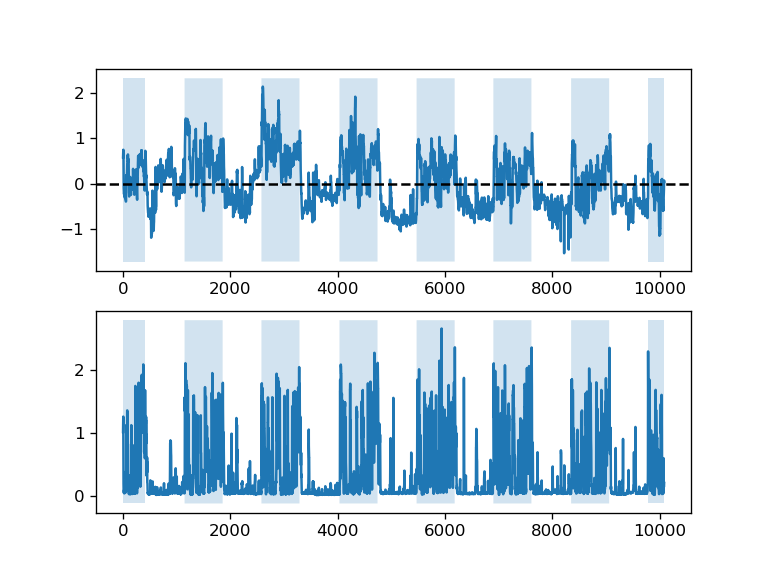

In [18]:
%matplotlib notebook
fig,ax = plt.subplots(2,1)

temperature = min_data['temp_rt_delta'].reset_index(drop=True).rolling(5,min_periods=1,center=True).median()
ax[0].plot(temperature)
ax[0].axhline(0,color='k',linestyle='--')
lims = ax[0].get_ylim()
ax[0].fill_between(temperature.index, lims[0], lims[1],where= min_data['isDay'].reset_index(drop=True)<.00001,alpha=.2)

motion = min_data['distance'].reset_index(drop=True).rolling(5,min_periods=1,center=True).median()
ax[1].plot(motion)
lims = ax[1].get_ylim()
ax[1].fill_between(temperature.index, lims[0], lims[1],where= min_data['isDay'].reset_index(drop=True)<.00001,alpha=.2)


<IPython.core.display.Javascript object>


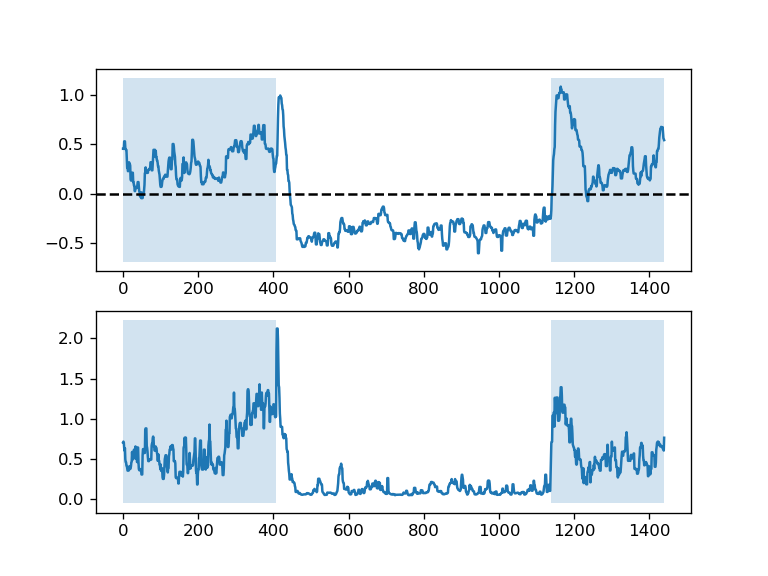

In [19]:
%matplotlib notebook
fig,ax = plt.subplots(2,1)

day_temperature = day_data['temp_rt_delta'].reset_index(drop=True).rolling(5,min_periods=1,center=True).median()
ax[0].plot(day_temperature)
ax[0].axhline(0,color='k',linestyle='--')
lims = ax[0].get_ylim()
ax[0].fill_between(day_temperature.index, lims[0], lims[1],where= day_data['isDay'].reset_index(drop=True)<.00001,alpha=.2)

day_motion = day_data['distance'].reset_index(drop=True).rolling(5,min_periods=1,center=True).median()
ax[1].plot(day_motion)
lims = ax[1].get_ylim()
ax[1].fill_between(day_temperature.index, lims[0], lims[1],where= day_data['isDay'].reset_index(drop=True)<.00001,alpha=.2)


/tmp/ipykernel_525101/165499521.py:15: RuntimeWarning: divide by zero encountered in true_divide
  period = 1 / frequencies


<IPython.core.display.Javascript object>


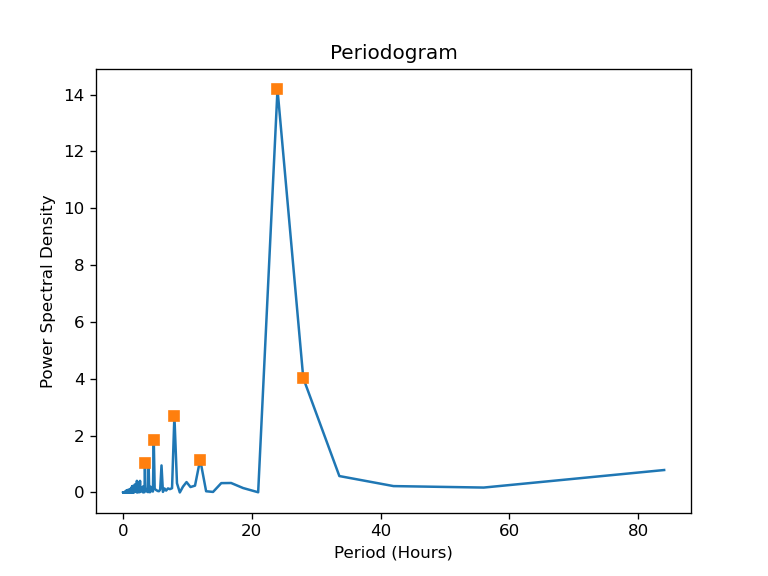

,Period (hours),Amplitude,Acrophase
0,28.005556,4.024779,16.240187
1,24.004762,14.187556,1.232068
2,12.002381,1.158062,6.895230
3,8.001587,2.700704,5.062536
4,4.800952,1.863473,1.015780
5,3.429252,1.029901,2.818753


In [21]:
# periodogramma che computa i picchi di oscillazione

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft
from statsmodels.stats.multitest import fdrcorrection


fs = 60
x = temperature

frequencies, power_spectrum = signal.periodogram(x, fs)
frequencies = frequencies[:-1]
power_spectrum = power_spectrum[:-1]
period = 1 / frequencies

sel = period <= 96
power_spectrum = power_spectrum[sel]
period = period[sel]

phase_spectrum = np.angle(fft.fft(x.values))
freq_fft = np.fft.fftfreq(len(x), 1/fs)
freq_pos = freq_fft >= 0
freq_fft = freq_fft[freq_pos]
phase_spectrum = phase_spectrum[freq_pos]
phase_spectrum = phase_spectrum[sel]

p_values = 1 - power_spectrum  # Convert power values to p-values
rejected, _ = fdrcorrection(p_values)

sorted_peaks = period[rejected]
sorted_amplitudes = power_spectrum[rejected]
sorted_phase = np.mod((2 * np.pi - phase_spectrum[rejected]) / (2 * np.pi) * period[rejected], period[rejected])
peaks_signi = pd.DataFrame({'Period (hours)': sorted_peaks, 'Amplitude': sorted_amplitudes, 'Acrophase': sorted_phase})
plt.figure()
plt.plot(period, power_spectrum)

plt.plot(period[rejected], power_spectrum[rejected], 's')

plt.xlabel('Period (Hours)')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram')


peaks_signi

In [56]:
#fig,ax=plt.subplots()

freq_fft = np.fft.fftfreq(len(x), 1/fs)
freq_pos = freq_fft>=0
freq_fft = freq_fft[freq_pos]
#ax.plot( freq_fft[freq_pos],'s' )
#ax.plot( frequencies ,'s')

for ind in range(len(frequencies)):
    print(ind, freq_fft[ind] - frequencies[ind])

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.

1233 0.0
1234 0.0
1235 0.0
1236 0.0
1237 0.0
1238 0.0
1239 0.0
1240 0.0
1241 0.0
1242 0.0
1243 0.0
1244 0.0
1245 0.0
1246 0.0
1247 0.0
1248 0.0
1249 0.0
1250 0.0
1251 0.0
1252 0.0
1253 0.0
1254 0.0
1255 0.0
1256 0.0
1257 0.0
1258 0.0
1259 0.0
1260 0.0
1261 0.0
1262 0.0
1263 0.0
1264 0.0
1265 0.0
1266 0.0
1267 0.0
1268 0.0
1269 0.0
1270 0.0
1271 0.0
1272 0.0
1273 0.0
1274 0.0
1275 0.0
1276 0.0
1277 0.0
1278 0.0
1279 0.0
1280 0.0
1281 0.0
1282 0.0
1283 0.0
1284 0.0
1285 0.0
1286 0.0
1287 0.0
1288 0.0
1289 0.0
1290 0.0
1291 0.0
1292 0.0
1293 0.0
1294 0.0
1295 0.0
1296 0.0
1297 0.0
1298 0.0
1299 0.0
1300 0.0
1301 0.0
1302 0.0
1303 0.0
1304 0.0
1305 0.0
1306 0.0
1307 0.0
1308 0.0
1309 0.0
1310 0.0
1311 0.0
1312 0.0
1313 0.0
1314 0.0
1315 0.0
1316 0.0
1317 0.0
1318 0.0
1319 0.0
1320 0.0
1321 0.0
1322 0.0
1323 0.0
1324 0.0
1325 0.0
1326 0.0
1327 0.0
1328 0.0
1329 0.0
1330 0.0
1331 0.0
1332 0.0
1333 0.0
1334 0.0
1335 0.0
1336 0.0
1337 0.0
1338 0.0
1339 0.0
1340 0.0
1341 0.0
1342 0.0
1343 0.0
1

2470 0.0
2471 0.0
2472 0.0
2473 0.0
2474 0.0
2475 0.0
2476 0.0
2477 0.0
2478 0.0
2479 0.0
2480 0.0
2481 0.0
2482 0.0
2483 0.0
2484 0.0
2485 0.0
2486 0.0
2487 0.0
2488 0.0
2489 0.0
2490 0.0
2491 0.0
2492 0.0
2493 0.0
2494 0.0
2495 0.0
2496 0.0
2497 0.0
2498 0.0
2499 0.0
2500 0.0
2501 0.0
2502 0.0
2503 0.0
2504 0.0
2505 0.0
2506 0.0
2507 0.0
2508 0.0
2509 0.0
2510 0.0
2511 0.0
2512 0.0
2513 0.0
2514 0.0
2515 0.0
2516 0.0
2517 0.0
2518 0.0
2519 0.0
2520 0.0
2521 0.0
2522 0.0
2523 0.0
2524 0.0
2525 0.0
2526 0.0
2527 0.0
2528 0.0
2529 0.0
2530 0.0
2531 0.0
2532 0.0
2533 0.0
2534 0.0
2535 0.0
2536 0.0
2537 0.0
2538 0.0
2539 0.0
2540 0.0
2541 0.0
2542 0.0
2543 0.0
2544 0.0
2545 0.0
2546 0.0
2547 0.0
2548 0.0
2549 0.0
2550 0.0
2551 0.0
2552 0.0
2553 0.0
2554 0.0
2555 0.0
2556 0.0
2557 0.0
2558 0.0
2559 0.0
2560 0.0
2561 0.0
2562 0.0
2563 0.0
2564 0.0
2565 0.0
2566 0.0
2567 0.0
2568 0.0
2569 0.0
2570 0.0
2571 0.0
2572 0.0
2573 0.0
2574 0.0
2575 0.0
2576 0.0
2577 0.0
2578 0.0
2579 0.0
2580 0.0
2

3939 0.0
3940 0.0
3941 0.0
3942 0.0
3943 0.0
3944 0.0
3945 0.0
3946 0.0
3947 0.0
3948 0.0
3949 0.0
3950 0.0
3951 0.0
3952 0.0
3953 0.0
3954 0.0
3955 0.0
3956 0.0
3957 0.0
3958 0.0
3959 0.0
3960 0.0
3961 0.0
3962 0.0
3963 0.0
3964 0.0
3965 0.0
3966 0.0
3967 0.0
3968 0.0
3969 0.0
3970 0.0
3971 0.0
3972 0.0
3973 0.0
3974 0.0
3975 0.0
3976 0.0
3977 0.0
3978 0.0
3979 0.0
3980 0.0
3981 0.0
3982 0.0
3983 0.0
3984 0.0
3985 0.0
3986 0.0
3987 0.0
3988 0.0
3989 0.0
3990 0.0
3991 0.0
3992 0.0
3993 0.0
3994 0.0
3995 0.0
3996 0.0
3997 0.0
3998 0.0
3999 0.0
4000 0.0
4001 0.0
4002 0.0
4003 0.0
4004 0.0
4005 0.0
4006 0.0
4007 0.0
4008 0.0
4009 0.0
4010 0.0
4011 0.0
4012 0.0
4013 0.0
4014 0.0
4015 0.0
4016 0.0
4017 0.0
4018 0.0
4019 0.0
4020 0.0
4021 0.0
4022 0.0
4023 0.0
4024 0.0
4025 0.0
4026 0.0
4027 0.0
4028 0.0
4029 0.0
4030 0.0
4031 0.0
4032 0.0
4033 0.0
4034 0.0
4035 0.0
4036 0.0
4037 0.0
4038 0.0
4039 0.0
4040 0.0
4041 0.0
4042 0.0
4043 0.0
4044 0.0
4045 0.0
4046 0.0
4047 0.0
4048 0.0
4049 0.0
4

5013 0.0
5014 0.0
5015 0.0
5016 0.0
5017 0.0
5018 0.0
5019 0.0
5020 0.0
5021 0.0
5022 0.0
5023 0.0
5024 0.0
5025 0.0
5026 0.0
5027 0.0
5028 0.0
5029 0.0
5030 0.0
5031 0.0
5032 0.0
5033 0.0
5034 0.0
5035 0.0
5036 0.0
5037 0.0
5038 0.0
5039 0.0
5040 0.0


IndexError: index 5041 is out of bounds for axis 0 with size 5041

In [12]:
power

NameError: name 'power' is not defined

In [16]:
import numpy as np
import pandas as pd
from scipy.signal import periodogram,fft
from scipy.stats import circmean
from statsmodels.stats.multitest import fdrcorrection

fs = 60  # Sampling frequency (1 minute)
t=temperature.index.values

# Compute the periodogram of the temperature signal
frequencies, power = periodogram(temperature, fs)
spectrum = fft.fft(temperature)
phase_spectrum = np.angle(spectrum)

# Perform FDR correction to adjust p-values
p_values = 1 - power  # Convert power values to p-values
rejected, _ = fdrcorrection(p_values)

# Set the threshold based on the corrected p-values
#threshold = np.max(power[rejected])

# Find frequencies above the threshold
significant_frequencies = frequencies[rejected] #power >= threshold]

# Calculate the period (in hours) of the significant frequencies
periods = 1 / significant_frequencies #* 60  # Convert to hours

# Calculate the acrophase (in hours) of the significant frequencies
acrophases = np.arccos(np.cos(2 * np.pi * significant_frequencies * t.mean())) / (2 * np.pi) * 24

# Calculate the mesor (mean value) of the temperature signal
mesor = np.mean(temperature)

# Create a pandas DataFrame to store the data of the significant components
data = pd.DataFrame({
    'Period (hours)': periods,
    'Acrophase (hours)': acrophases,
})

# Print the mesor and significant components
print("Mesor:", mesor)
print("Significant Components:")
print(data)


ImportError: cannot import name 'fft' from 'scipy.signal' (/home/oldboy/anaconda3/lib/python3.9/site-packages/scipy/signal/__init__.py)

<IPython.core.display.Javascript object>


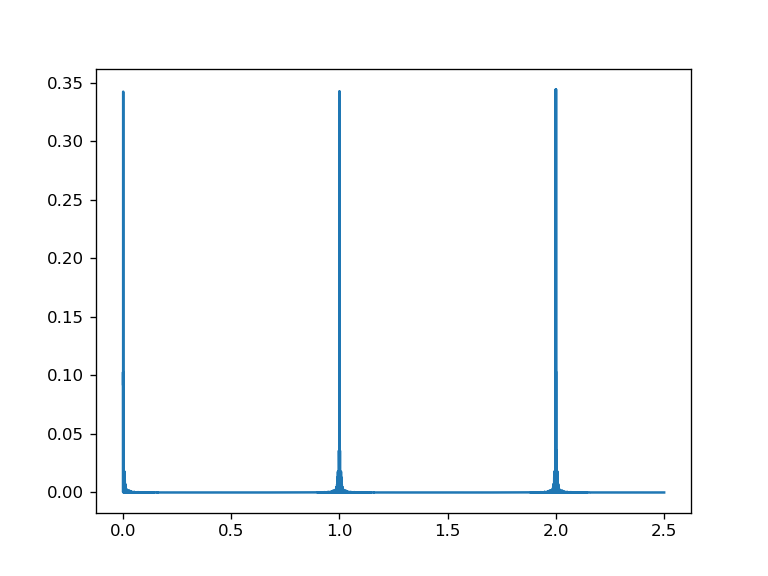

In [78]:
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle

# Generate a sample signal with multiple dominant frequencies
fs = 60
t = temperature.index
x = temperature

# Perform Lomb-Scargle periodogram analysis
frequency, power = LombScargle(t, x).autopower()

# Create a DataFrame to store the periodogram analysis results
df = pd.DataFrame({'Frequency': frequency, 'Power': power})

# Sort the peaks based on power (amplitude)
df = df.sort_values(by='Power', ascending=False)

# Print the DataFrame
fig,ax = plt.subplots()
plt.plot(frequency,power)

In [36]:
frequencies

array([  0.   ,   5.625,  11.25 ,  16.875,  22.5  ,  28.125,  33.75 ,
        39.375,  45.   ,  50.625,  56.25 ,  61.875,  67.5  ,  73.125,
        78.75 ,  84.375,  90.   ,  95.625, 101.25 , 106.875, 112.5  ,
       118.125, 123.75 , 129.375, 135.   , 140.625, 146.25 , 151.875,
       157.5  , 163.125, 168.75 , 174.375, 180.   , 185.625, 191.25 ,
       196.875, 202.5  , 208.125, 213.75 , 219.375, 225.   , 230.625,
       236.25 , 241.875, 247.5  , 253.125, 258.75 , 264.375, 270.   ,
       275.625, 281.25 , 286.875, 292.5  , 298.125, 303.75 , 309.375,
       315.   , 320.625, 326.25 , 331.875, 337.5  , 343.125, 348.75 ,
       354.375, 360.   , 365.625, 371.25 , 376.875, 382.5  , 388.125,
       393.75 , 399.375, 405.   , 410.625, 416.25 , 421.875, 427.5  ,
       433.125, 438.75 , 444.375, 450.   , 455.625, 461.25 , 466.875,
       472.5  , 478.125, 483.75 , 489.375, 495.   , 500.625, 506.25 ,
       511.875, 517.5  , 523.125, 528.75 , 534.375, 540.   , 545.625,
       551.25 , 556.

In [12]:

def parsedate(date):
    try:
        return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').day
    except:
        return np.nan

#for i,row in df.iterrows():
#     print( int( row['Date'].split(' ')[0].split('-')[-1]) ) 
df['Day'] = df['Date'].apply(lambda x: int(x.split(' ')[0].split('-')[-1]), meta=('int') )
df['Day_rel'] = df['Day'] - df['Day'].unique().compute().min()
#df['Day_rel'] = df['Day']-df['Day'].loc[0]
df.head()

C:\Users\pupil\anaconda3\lib\site-packages\dask\dataframe\core.py:6169: FutureWarning: Meta is not valid, `map_partitions` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


,index_old,ID,Date,timeStamp,hour,minute,RT,isDay,temp_avg,temp_med,temp_max,centroid_x,centroid_y,distance,Day
0,0,1.0,2023-05-19 12:00:00,2027.809737,12.0,720.0,20.486520,1.0,25.495870,25.495870,28.647199,76.937322,45.588590,NaN,19
1,1,2.0,2023-05-19 12:00:00,2028.015251,12.0,720.0,20.493791,1.0,25.325776,25.325776,28.440092,78.679304,45.558714,1.742238,19
2,2,3.0,2023-05-19 12:00:00,2028.127524,12.0,720.0,20.500572,1.0,25.444307,25.444307,28.552307,78.295316,45.377368,0.424657,19
3,3,4.0,2023-05-19 12:00:00,2028.245897,12.0,720.0,20.496732,1.0,25.381336,25.381336,28.466030,77.857371,44.580024,0.909700,19
4,4,5.0,2023-05-19 12:00:00,2028.355840,12.0,720.0,20.492320,1.0,25.401985,25.401985,28.640290,78.615925,44.828350,0.798167,19


In [22]:
df['Day_rel'].unique().compute()

0    0
1    1
2    2
3    3
Name: Day_rel, dtype: int64

In [17]:

#df['mot_dist'] = np.sqrt((df['centroid_x'] - df['centroid_x'].shift(1))**2 + (df['centroid_y'] - df['centroid_y'].shift(1))**2)
#df['mot_dist'] = df['mot_dist'].fillna(0)



avg_min
#avg_min

,ID,timeStamp,hour,RT,isDay,temp_avg,temp_med,temp_max,centroid_x,centroid_y,distance
0,1.336434e+06,155847.136659,6.0,20.928277,0.000000,24.925562,24.925562,27.409255,45.632617,75.221100,0.663761
1,1.339281e+06,156172.399806,6.0,20.909420,0.597041,25.012292,25.012292,27.473522,44.624407,77.711148,0.630961
2,1.339671e+06,156218.470433,6.0,20.905223,1.000000,24.838781,24.838781,27.161659,48.362016,86.507362,0.468760
3,1.343349e+06,156640.463707,6.0,20.903320,1.000000,24.810668,24.810668,27.235981,51.050258,91.076157,0.222031
4,1.343131e+06,156616.988766,6.0,20.898115,1.000000,24.820788,24.820788,27.236991,48.647908,89.847007,0.322865
...,...,...,...,...,...,...,...,...,...,...,...
1436,1.345731e+06,156909.814315,6.0,20.934016,0.000000,24.817289,24.817289,27.277771,47.785162,85.979589,0.530997
1437,1.341345e+06,156406.007745,6.0,20.939502,0.000000,24.786358,24.786358,27.323865,44.175829,81.319092,0.785412
1438,1.336503e+06,155852.942435,6.0,20.933071,0.000000,24.851544,24.851544,27.305942,46.083188,80.210620,0.840904
1439,1.334818e+06,155660.904451,6.0,20.906522,0.000000,24.913386,24.913386,27.426630,43.668838,81.474248,0.728567


<IPython.core.display.Javascript object>


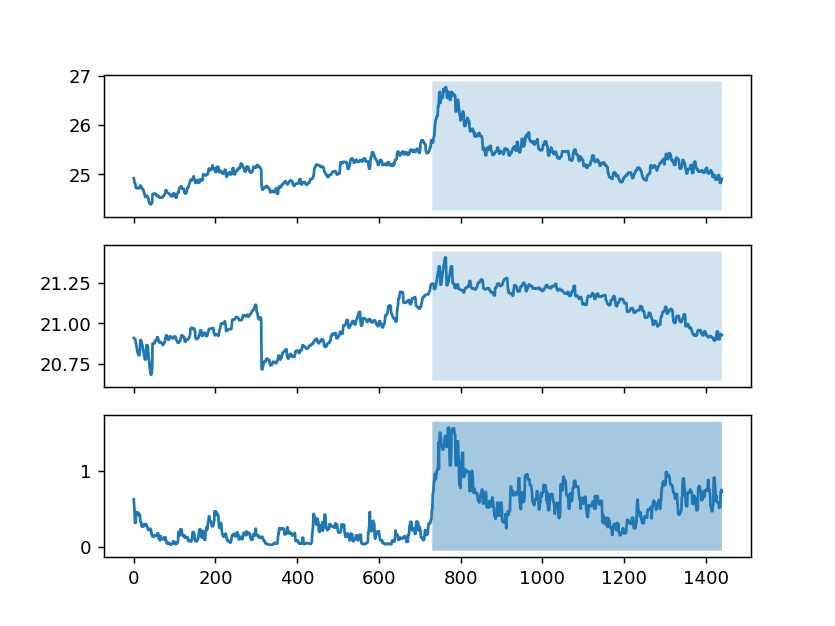

In [18]:

%matplotlib notebook

fig,ax = plt.subplots(3,1,sharex=True)

avg_min[['temp_avg','RT','distance']] = avg_min[['temp_avg','RT','distance']].rolling(5,center=True,min_periods=1).median()
ax[0].plot(avg_min.index,avg_min['temp_avg'])
ylim = ax[0].get_ylim()
ax[0].fill_between(avg_min.index,y1=ylim[0],y2=ylim[1], where=avg_min['isDay']<0.5,alpha=.2)

ax[1].plot(avg_min.index,avg_min['RT'])
ylim = ax[1].get_ylim()
ax[1].fill_between(avg_min.index,y1=ylim[0],y2=ylim[1], where=avg_min['isDay']<0.5,alpha=.2)

ax[2].plot(avg_min.index,avg_min['distance'])
ylim = ax[2].get_ylim()
ax[2].fill_between(avg_min.index,y1=ylim[0],y2=ylim[1], where=avg_min['isDay']<0.5,alpha=.4)


In [23]:


pth = Path(r'C:\Users\pupil\Downloads\thermal_behaviour_72_h')


def readTher(fnames):
    df = dd.read_csv((fnames/'data.csv').as_posix(), sep=';', skiprows=1, 
                     assume_missing=True)  
    df['distance'] = df.map_partitions(euclid) # da cambiare
    df = df.reset_index().rename(columns={'index':'index_old'})

    avg_min = df.groupby(['ID']).mean()
    avg_min = df.groupby(['minute']).mean()

    avg_min = avg_min.compute()
    avg_min = pd.concat([avg_min.loc[407:],avg_min.loc[:407]]).reset_index(drop=True)
    return avg_min

fnames = pth / '20230519_113859-ROI_*-WT_*'
wt = readTher(fnames)
fnames = pth / '20230519_113859-ROI_*-KO_*'
ko = readTher(fnames)


<IPython.core.display.Javascript object>


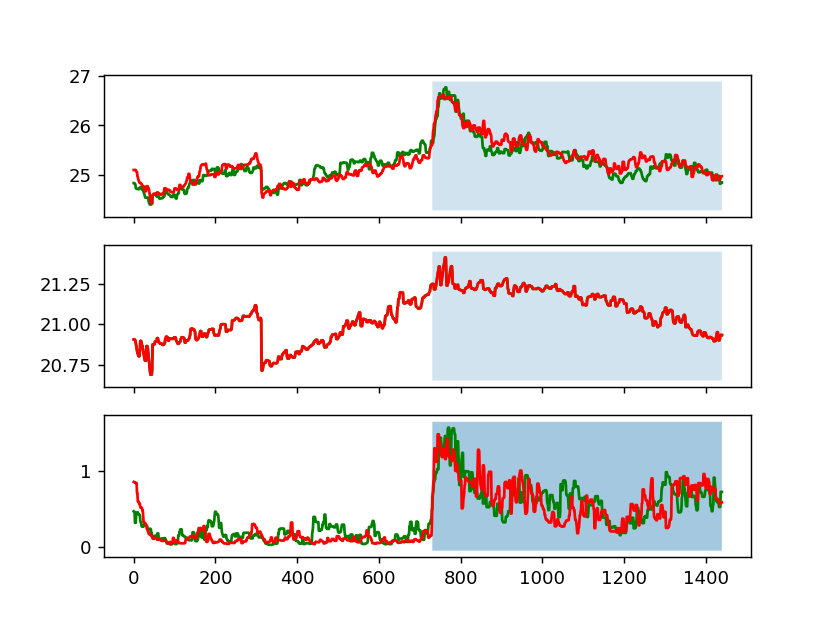

In [29]:
%matplotlib notebook

fig,ax = plt.subplots(3,1,sharex=True)

wt[['temp_avg','RT','distance']] = wt[['temp_avg','RT','distance']].rolling(5,center=True,min_periods=1).median()
ko[['temp_avg','RT','distance']] = ko[['temp_avg','RT','distance']].rolling(5,center=True,min_periods=1).median()

ax[0].plot(wt.index,wt['temp_avg'],'g')
ax[0].plot(ko.index,ko['temp_avg'],'r')
ylim = ax[0].get_ylim()
ax[0].fill_between(wt.index,y1=ylim[0],y2=ylim[1], where=wt['isDay']<0.5,alpha=.2)

ax[1].plot(wt.index,wt['RT'],'g')
ax[1].plot(ko.index,ko['RT'],'r')
ylim = ax[1].get_ylim()
ax[1].fill_between(wt.index,y1=ylim[0],y2=ylim[1], where=wt['isDay']<0.5,alpha=.2)

ax[2].plot(wt.index,wt['distance'],'g')
ax[2].plot(ko.index,ko['distance'],'r')
ylim = ax[2].get_ylim()
ax[2].fill_between(wt.index,y1=ylim[0],y2=ylim[1], where=wt['isDay']<0.5,alpha=.4)

